In [4]:
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from matplotlib import mlab
%pylab inline
import util
import importlib
importlib.reload(util)
util.figsize()
# num
import pandas as pd
from scipy import signal, stats, ndimage

Populating the interactive namespace from numpy and matplotlib


In [5]:
# subplot ref
splot = subplot

Dutch Data Science Week 2018

# Signal Processing for Data Science

A.k.a. From Fourier to Deep Convnets

### Introduction (09:00 - 10:45)
- Signal processing applications
- Convolution
- Fourier analysis (only for intuition and application)

### Feature engineering (11:00 - 13:00)
- 1D signals: filter banks, pooling
- 2D signals: bag-of-words

### Feature learning (14:00 - 15:15)
- PCA / LDA
- Convolutional neural network
    
### Speech processing hackathon (15:30 - ?)
- Speaker / gender / age / nationality recognition...
- ...based on Fourier / bag-of-words / convnet

And a lot of numpy fetish ;)

I have coded everything up in Python using Jupyter notebooks, and I'm gonna present it to you - so you will be hearing me a lot. But of course interaction is appreciated so we can make it a joint effort.

There is quite some diversity in today's group, and I gonna try to make everybody happy;) I guess I should be less heavy on the image processing part as that is the least valuable, but the material is there.

In general it might be tough but I think you'll find it very interesting. Ask me anything.

All material is available on [https://github.com/godatadriven/ddsw-2018-dsp-workshop](https://github.com/godatadriven/ddsw-2018-dsp-workshop). I am available at the end of the day and by email to help out with the installation if required.

## About us

- Ivo Everts, Data Scientist at GoDataDriven, BSc+MSc+PhD in AI (biased to Computer Vision). Large projects at ING and NS.

- Marcel Raas: Data Scientist at GoDataDriven, BSc+MSc+PhD in physics

- Gabrielle Modena: former collegue deserving kudos here

- You:

## Introduction

- 'Traditional data' comes from the (relational) database in rows and columns
- Data is usually stored in a dataframe for processing, in Python, R, Spark, ...
- Columns typically represent clearly defined variables
<p>
```
id  age  gender  city  income
01   35       m   ams    NULL
02   20       m   rot   40000
03   20       f   rot   35000
04   40       f   ams   50000
..  ...  ......  ....  ......
```

- Apart from data cleaning and basic preprocessing, the data can be used as such by a machine learning algorithm
- Often, the aim to predict one of the columns based on the others, after having identified that as being a usefull case

### Nontraditional data	
- Non- (or at least less-) traditional data is e.g. text, speech, music, video, images, financial series, seismic waves, wifi/bluetooth counts, ...
- In a machine learning context, all those data have in common that they are *unstructured* and thus some sort of *feature extraction* needs to precede further processing

<center><img src=images/plot_ML_flow_chart_1.png width=70%></center>

- From text we can not just use the words.
- From images we can not just use the pixels.
- From financial transactions we can not just use the amounts.
- ... why??

- These data can broadly be called *digital signals*: a function that yields some value given some space/time input.
- *text* is perhaps an outlier in this context - and it should be as it is being covered in a seperate lecture ;)
    - but go through the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) as we'll be using it for representing signals as well.

### Applications

- Speech and music recognition in audio signals
    - [Voice recognition](https://www.microsoft.com/en-us/research/project/speaker-identification-whisperid/)
	- [Voice control](http://www.howtechnologywork.com/wp-content/uploads/2014/11/How-Siri-Technology-Work1.png)
    - [Content-based music search](http://www.shazam.com/company)
- Visual recognition in images and video
    - [Face recognition](https://www.facebook.com/facialrecognitionapp/)
    - [Crowd analysis](https://www.youtube.com/watch?v=7V8jrdH5tAQ)
	- [Content-based image and video search](http://techcrunch.com/2014/09/15/qualcomm-quietly-acquires-ai-based-image-recognition-startup-euvision/)
	- [Security](https://www.youtube.com/watch?v=Qx602tAsbX8)
- Profit extraction from financial signals
    - [Forecasting stock market, currency exchange, credit rating, default probability, money laundering](http://www.fsplab.com/publications/4586238445)
    - [Financial network analysis](http://www.imf.org/external/pubs/ft/survey/so/2014/RES052314A.htm)

## Digital signal processing

A signal can broadly be viewed as a function

$$f(\mathbf{t}) \rightarrow \mathbf{v}$$ 
$$\mathbf{t} \in \mathcal{R}^N, \mathbf{v} \in \mathcal{R}^M.$$

Thus, mathematical operators can be applied to signals - this is already quite different from traditional data!

Usually, **t** denotes a step in time (i.e. *N=1*) and **v** is some scalar measurement at the moment of **t** (i.e. *M=1*). These are time series such as simple sensor measurements (temperature, humidity, seismic waves, people counts), financial transactions, etc. For e.g. images, **t** denotes image coordinates (row, column) and **v** is the (R,G,B) pixel value.

We will be shifting back and forth between signal dimensionality in this workshop.

In [6]:
# some quasi-periodic function definition
def fn(t):
    return sin(t) + cos(t*2) + 2*random.rand(len(t))

In [7]:
def plot_f(f_data=None):
    if f_data is None:
        t = arange(31)
        v = fn(t)
    else:
        t = f_data[0]
        v = f_data[1]
    plot(t, v); util.xlabel('t'); util.ylabel('f(t)');

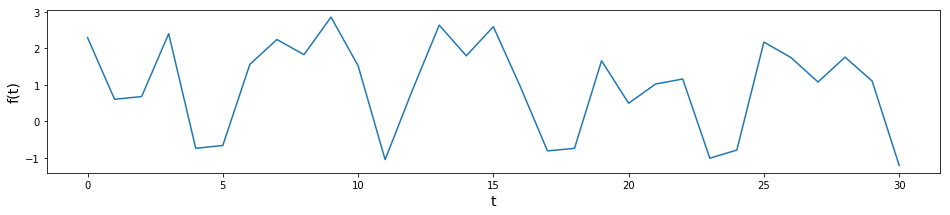

In [8]:
plot_f();

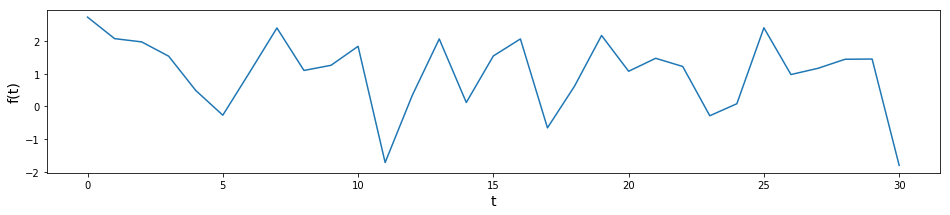

In [9]:
plot_f()

### Feature extraction

Such a raw signal can in general not be used as such for data representations in a machine learning setup, so we need to perform some sort of preprocessing.

In [10]:
def plot_inout_example():
    
    # time period (days) to consider
    ndays = 101

    # fraction of days on which a transaction occurs
    pos_prob = 1/1.1; neg_prob = 1/1.05

    # transactions
    pos = (random.rand(ndays) < pos_prob) * fn(arange(ndays)) / pos_prob
    neg = (random.rand(ndays) < neg_prob) * fn(arange(ndays)) / neg_prob
    cpn = cumsum(pos) - cumsum(neg)
    scpn = sort(cpn)

    # plot
    pos_nz = pos.nonzero()[0]; neg_nz = neg.nonzero()[0]
    plot(pos_nz, pos[pos_nz], 'g*');
    plot(neg_nz, -neg[neg_nz], 'r*');
    plot(cpn, 'b-');
    plot([0, ndays-1], [scpn[-5], scpn[-5]], 'm:');
    util.legend(['in','out','cumulative','some threshold']); util.xlabel('day'); util.ylabel('amount');

How would you preprocess the data involved in the following tasks:

- Bluetooth detections for counting people in a certain area
- Financial transactions for liquidity forecasting
- Financial transactions for discriminating between individuals and companies
- Seismic waves for early earthquake warnings

Are there common features among those data? What are common challenges for feature extraction?

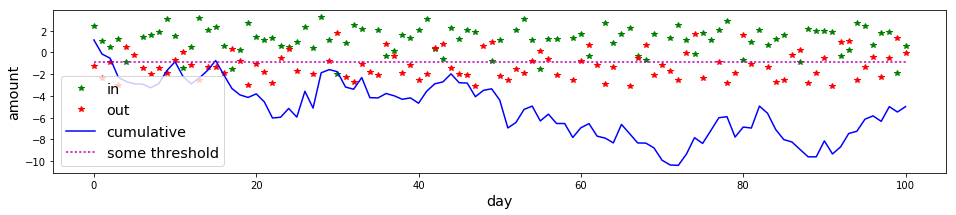

In [11]:
util.figsize(16, 3); plot_inout_example(); util.figsize()

There are challenges due to noise and signal length; interesting features lie in the periodicity of the signal; this contrasts with simple global statistics such as max, mean

### Convolution

The preprocessing of and feature extraction from signals typically involves an operation called *convolution*, commonly denoted as $$(f * g)(t)$$ where *f* is our original function, and *g* is some other function.

Note that we are dealing with discrete signals. This means that our data consists of a finite set of measurements at discrete steps, i.e. *samples*. This allows for a user-friendly mathematical notation of the convolution: $$(f*g)[\tau]=\sum_{t=-T}^T f[\tau-t]g[t].$$
<p>
<center><img src=images/1dconv.png></center>

#### Filtering with the Gaussian kernel

Probably the most common operation in signal processing is *smoothing* - which is achieved by convolving the signal _f_ with a (Gaussian) smoothing filter _g_. This can be used for noise reduction in e.g. audio signals, and blurring of images.

In [12]:
def plot_gaussian_convolution_example():
    t = np.arange(31); v = fn(t); g = signal.gaussian(3, 1);
    plot(t, v);
    plot(t, convolve(v, g/sum(g), 'same'));
    util.legend(['signal', 'smoothed signal']);
    util.title('Convolving a signal with a Gaussian kernel');
    util.xlabel('t'); util.ylabel('f(t)'); xlim(0, 30)

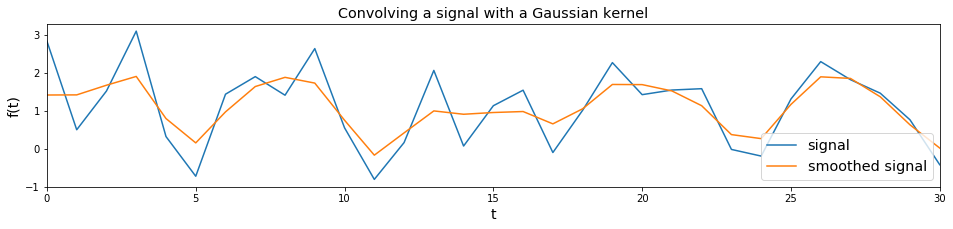

In [13]:
plot_gaussian_convolution_example()

In [14]:
def plot_gaussians():
    # parameters for data sampling with signal.gaussian
    num_samples, mean, std = 9, 0, 1
    
    # prevent insanity
    assert(num_samples % 2 == 1 and type(num_samples) == int)
    
    # define range, intentionally abusing the oddness and integerness of num_samples
    lb, hb = mean - num_samples/2, mean + num_samples/2
    
    # obtain a zero-mean 'gaussian window'
    g = signal.gaussian(num_samples, std)
    
    # obtain higher resolution samples to obtain 'the bell'
    sub_x = arange(lb, hb, .1)
    sub_g = stats.norm.pdf(sub_x, mean, std)
    
    # display a couple of gaussian flavours
    plot(arange(lb+.5, hb+.5), g);
    plot(sub_x, sub_g, 'b-');
    plot(sub_x, sub_g/max(sub_g), 'b.');
    util.legend(['signal.gaussian','stats.norm.pdf','scaled gaussian pdf']);

Basically any numericish package/module/language has functionality for performing convolution and associated kernel creation. It is an elementary operation for vector/matrix manupilation and thus relevant in particular to DSP.

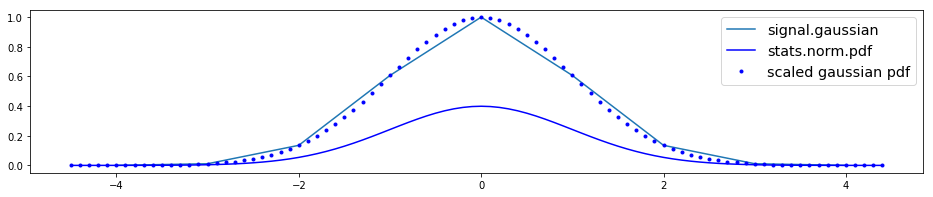

In [15]:
plot_gaussians() # please go through the code

**Assignment**: Now we know, how to perform a convolution. We also know what a Gaussian filter looks like. Can you code up the result of convolving the signal *[1,4,6,2,8,3,6,2,2,4]* with a Gaussian-like filter? You might want to either pad the original signal or truncate the result.

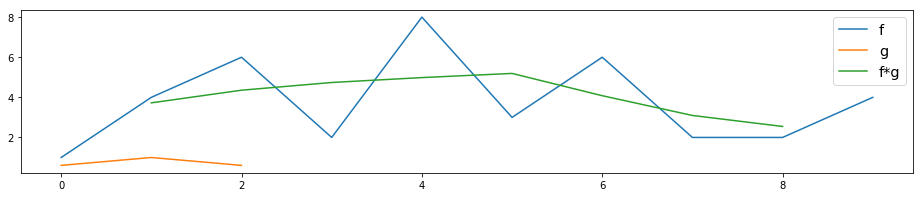

In [53]:
# possible answer
v = [1,4,6,2,8,3,6,2,2,4]
gw = 3; s = int(gw/2);
g = signal.gaussian(gw, 1); gs = sum(g);
vg = [ sum([v[i+j] * g[j+s] for j in range(-s, s+1)]) 
       for i in range(s, len(v)-s) ]
plot(v); plot(g); plot(arange(s,s+len(vg)), array(vg)/gs);
util.legend(['f','g','f*g']);

#### Multi-scale processing

The Gaussian kernel is parameterized by its standard deviation, so we can control that. 

In [17]:
# showcase filters of varying sizes
sigmas = append(0, power([0.5, 1, 2], 0.5));
def plot_multiscale_convolution_example():
    sub_x = arange(-5, 5, .1)
    t = arange(31); v = fn(t);
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
    for sigma in sigmas:
        splot(gs[0]).plot(sub_x, stats.norm.pdf(sub_x, 0, sigma))
        splot(gs[1]).plot(t, ndimage.filters.gaussian_filter(v, sigma))
    splot(gs[0]); axis([-5, 5, 0, 1.2]); util.title('Kernels')
    util.legend(['sigma = {:.2f}'.format(sigma) for sigma in sigmas])
    splot(gs[1]); util.title('Convolved signal')
    xlim(0, 30)

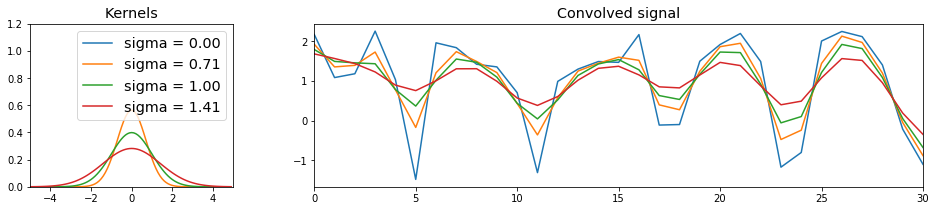

In [18]:
# go through the code
plot_multiscale_convolution_example()

What is happening here?

#### Kernel density estimation

As an important side note of statistical nature: given the observed density below, how would convolution come in handy?

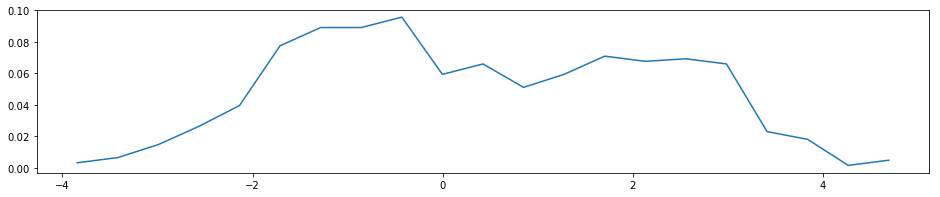

In [54]:
# observe some random variable, sometimes
observations = np.concatenate((random.randn(341)-1,\
                               random.randn(265)+2))

# model the observations using a histogram
counts, bins = histogram(observations, 21);
plot((bins[:-1]+bins[1:])/2, counts/float(sum(counts)));

In [20]:
# throw in a function, reference global vars
# I'd rather be lazy than tired
def plot_gaussian_kde_example():
    # plot again for reference
    plot((bins[:-1]+bins[1:])/2, counts/float(sum(counts)));
    # kernel density estimation
    kernel = stats.gaussian_kde(observations)
    plot(bins, kernel(bins));
    plot(bins, kernel(bins)/sum(kernel(bins)));
    # the gaussian kernel
    kernel_tick = arange(-3, -1, .1)
    kernel_vals = stats.norm.pdf(kernel_tick, -2, sqrt(kernel.covariance[0][0]))
    plot(kernel_tick, kernel_vals/sum(kernel_vals))
    util.legend(['observations','unnormalized estimated density', 'estimated density', 'gaussian kernel'])

Kernel Density Estimation using a Gaussian kernel

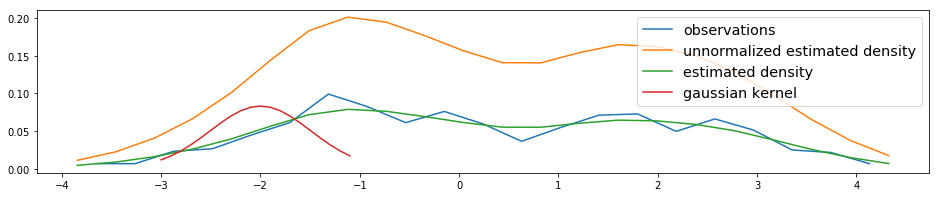

In [21]:
plot_gaussian_kde_example()

### Higher dimensions... images!

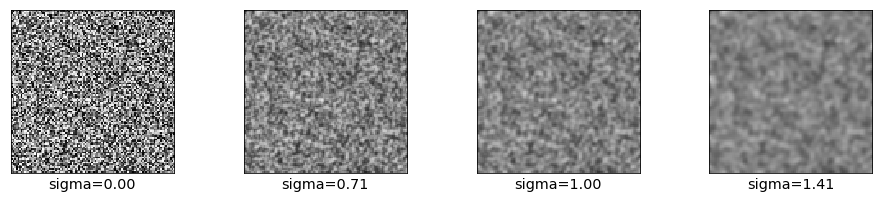

In [22]:
# example of smoothing a 2D signal - i.e. image blurring!
image = random.rand(100, 100)
for sigma, i in zip(sigmas, range(len(sigmas))):
    splot(1, len(sigmas), i+1);
    util.imshow(ndimage.filters.gaussian_filter(image, sigma));
    util.xlabel('sigma={:.2f}'.format(sigma))

**Assignment**: plot the filter that was used for image blurring. If that does not work out, draw it on paper. Does all this comply to our 'signal definition'?

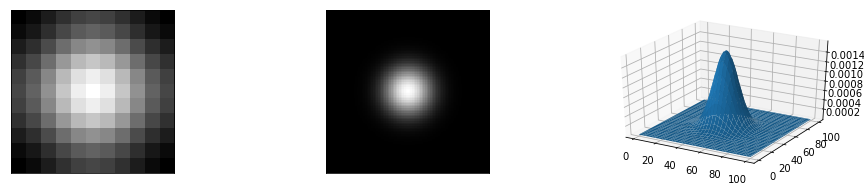

In [23]:
# possible answers
splot(131);
image = zeros((11, 11)); image[5, 5] = 1;
util.imshow(util.imscale(ndimage.filters.gaussian_filter(image, 3)))
splot(132);
x, y = meshgrid(range(101), range(101))
z = mlab.bivariate_normal(x, y, mux=50, muy=50, 
                                sigmax=10, sigmay=10)
util.imshow(util.imscale(z))
splot(133, projection='3d').plot_surface(x, y, z);

So, I guess you are starting to get those convolutional net imagery...!?

<img src="images/convolutional.jpg">

Besides smoothing, one of the most often used applications of convolution on images results in **edge detection**.

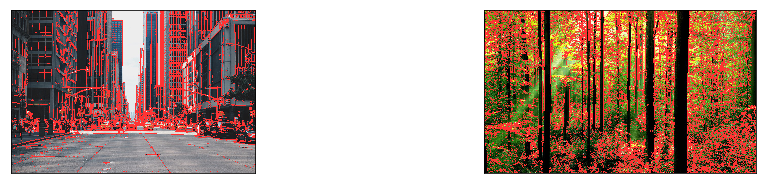

In [24]:
city = util.imread('city.jpg');
forest = util.imread('forest.jpg');
splot(121); util.imshow(util.detect_edges(city));
splot(122); util.imshow(util.detect_edges(forest));

What use case can you come up with in which edge detection is useful in the context of these two images? What further processing would be usefull?

In [25]:
# read one sample from 16 tiled mnist digits
def get_digit(digit=1, sub_idx=-1):
    # map between actual digits and (row, col) indices in the tiled digit image
    digit_idx = {0: [(0,1), (2,1)],
                 1: [(0,3), (2,3)],
                 3: [(1,0), (1,2), (3,0)],
                 4: [(0,2), (2,0)],
                 5: [(0,0)],
                 6: [(1,0), (1,3), (3,0)],
                 8: [(3,1)],
                 9: [(2,2), (3,3)]}
    assert(digit in digit_idx)
    # choose one of the available options
    assert(sub_idx < len(digit_idx[digit]))
    sub_idx = random.choice(len(digit_idx[digit])) if sub_idx < 0 else sub_idx
    idx = digit_idx[digit][sub_idx]
    # number of tiles (per dimension)
    ntiles = 4
    # read the digits
    tiles = util.imread('images/mnist_sample.png', 'F')
    # crop the requested tile
    height = tiles.shape[0] / ntiles
    width = tiles.shape[1] / ntiles
    return tiles[idx[0]*height:(idx[0]+1)*height, idx[1]*width:(idx[1]+1)*width]

Let's start with less complex images

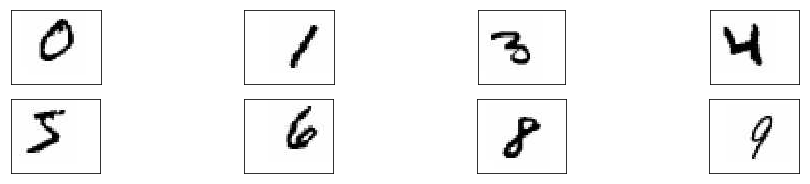

In [26]:
# not all digits are available in our mini sample
digits = [0,1,3,4,5,6,8,9]
for i in range(len(digits)):
    splot(2, 4, i+1);
    util.imshow(get_digit(digits[i]));

In [27]:
# plot the given image both on axes and on canvas
def hybrid_image_plot(im):
    util.figsize(16, 4)
    x, y = meshgrid(arange(im.shape[0]), arange(im.shape[1]), indexing='ij')
    fig = figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.view_init(80, 20)
    ax.plot_surface(x, y, im, cmap='Blues'); util.title('Image function')
    util.ylabel('column'); util.xlabel('row');
    fig.add_subplot(122)
    util.imshow(im); util.title('Image')
    util.figsize()

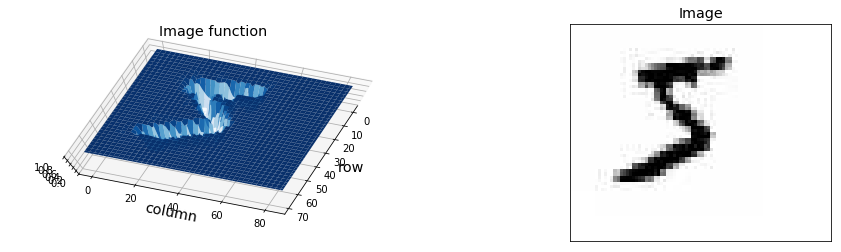

In [28]:
hybrid_image_plot(get_digit(5))

**Assignment**: understand **exactly** how these images come to be and what that means. (This should already have become clear in the smoothing excercise but better be sure).

Now we try to understand how edge detection works

In [29]:
def show_image_derivatives(im):
    util.figsize(18, 3)
    splot(141); util.imshow(im); util.title('Image')
    splot(142); util.imshow(util.image_derivative(im, 'x')); util.title('dx')
    splot(143); util.imshow(util.image_derivative(im, 'y')); util.title('dy')
    splot(144); util.imshow(util.image_derivative(im, 'grad')); util.title('dx/dy')
    util.figsize()

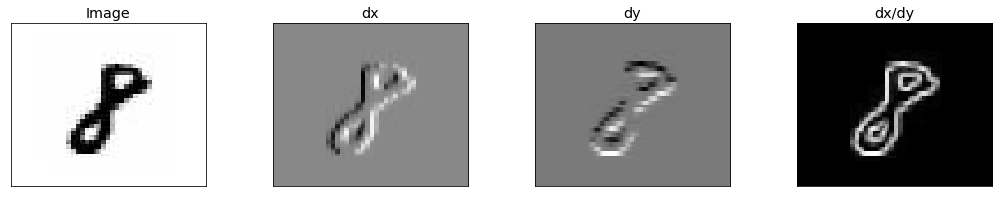

In [30]:
digit = get_digit(8)
show_image_derivatives(digit)

Any thoughts on what this is and how these images are created? What is the so called _image gradient_?

### Gradient

The image gradient is defined as the vector $[\delta_x, \delta_y]$. It's magnitude $\sqrt{{\delta_x}^2+{\delta_y}^2}$ corresponds to the amount of _contrast_; it's orientation $\arctan(\delta_y / \delta_x)$ corresponds to the _edge direction_.

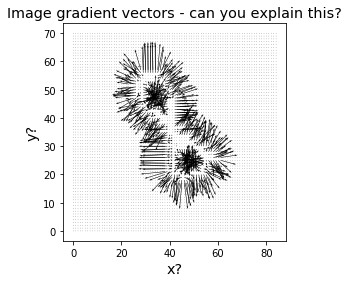

In [59]:
util.figsize(5,5)
dx = util.image_derivative(digit, 'x', False)
dy = util.image_derivative(digit, 'y', False)
util.figsize(4,4); quiver(10*dx, 10*dy); util.figsize();
util.title('Image gradient vectors - can you explain this?');
util.xlabel('x?'); util.ylabel('y?')

Let's consider even simpler images

In [32]:
# First, I need a volunteer to unravel this piece of code
def make_border_image(n = 100):
    bim = zeros((n, n), dtype='float')
    i, j = meshgrid(range(n), range(n), indexing='ij')
    # upper left quadrant
    bim[:n/2,:n/2] = 1
    # lower right quadrant
    bim[n/2:,n/2:] = 1
    # upper left circle
    bim[sqrt(i**2+j**2) < n/3] = 0
    # lower right circle
    bim[sqrt((n-i)**2+(n-j)**2) < n/3] = 0
    return bim

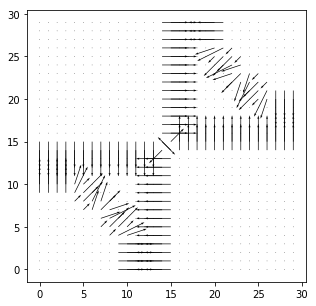

In [33]:
bim = make_border_image(30)
quiver(util.image_derivative(bim, 'x', False),
       util.image_derivative(bim, 'y', False));

Based on the code ($make\_border\_image()$) and quiver plot, can you mentally reconstruct the original image?

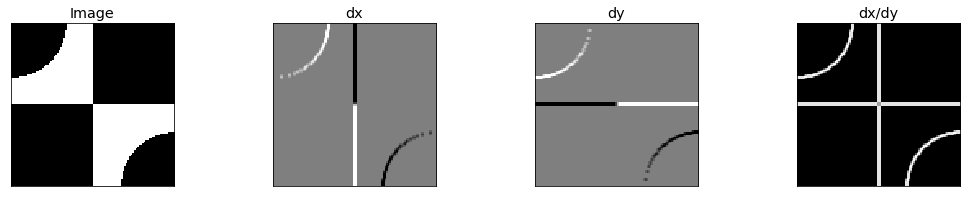

In [34]:
bim = make_border_image(100)
show_image_derivatives(bim)

**Assignment**: manually create and apply the derivative filter that was used to create these images. You can work your way through all code so far in the notebook if needed. Hint: you will have to create a KxD kernel which is applied to a MxN matrix using *ndimage.convolve*.

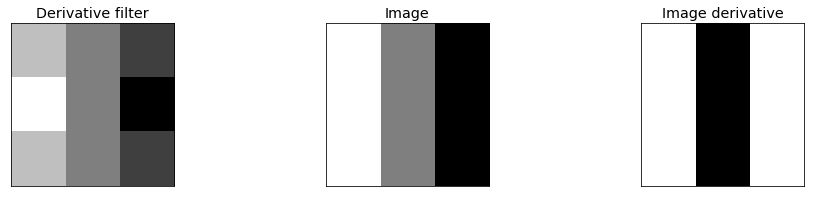

In [35]:
# possible answer
im = array([[1, 0.5, 0],[1, 0.5, 0],[1, 0.5, 0]])
smoothing  = array([+1, +2, +1]).reshape(3,1)
derivative = array([+1,  0, -1]).reshape(1,3)
# combine by using the cross product
sobel_derivative = dot(smoothing, derivative)
# note that matplotlib's imshow 'does something' when displaying tiny images
splot(131);
util.imshow(util.imscale(sobel_derivative)); util.title('Derivative filter')
splot(132);
util.imshow(im); util.title('Image')
splot(133);
util.imshow(util.imscale(ndimage.convolve(im, sobel_derivative)));
util.title('Image derivative')

Now for *dy* as well

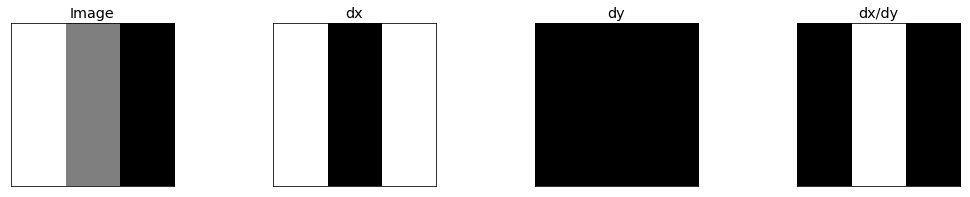

In [36]:
# check
show_image_derivatives(im)

OK?

#### The Gaussian derivative filter

Convolving a signal with a Gaussian filter smooths the signal. Convolving a signal with a 'difference' filter like Sobel sort of differentiates the signal. Convolving a signal with a Gaussian derivative filter...

In [37]:
def show_gaussian_orders():
    pim = zeros((11,11));
    pim[5,5] = 1
    gaussian_orders = [ array([[0,0]]) ] + \
                      [ i*array([[1,0],[0,1],[1,1]]) for i in [1,2,3] ]
    nrows = len(gaussian_orders); ncols = max([len(l) for l in gaussian_orders]);
    nrow = 0;
    util.figsize(18,8)
    for i in range(nrows):
        nrow += 1; ncol = 0;
        for j in range(len(gaussian_orders[i])):
            ncol += 1
            splot(nrows, ncols, (nrow-1)*ncols+ncol);
            util.imshow(util.imscale(ndimage.gaussian_filter(pim, 1, order=gaussian_orders[i][j])))
            util.title(str(gaussian_orders[i][j]))
        ncol = 0;
    util.figsize()

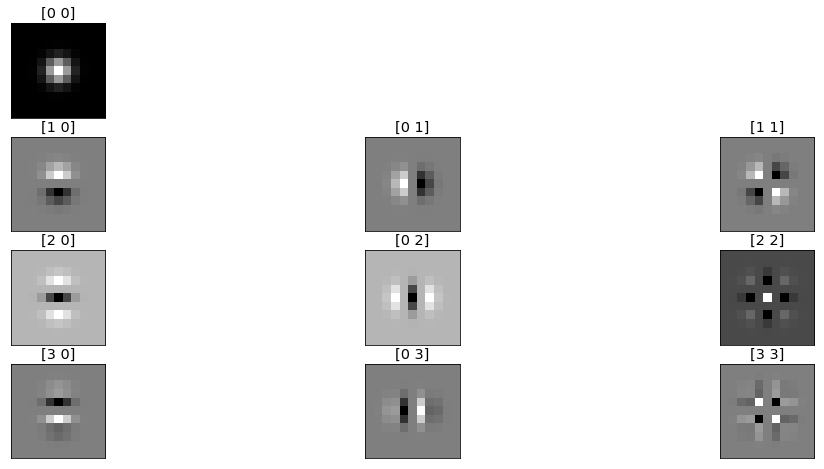

In [38]:
show_gaussian_orders()

...is the appropriate way to extract differential features from an image.

In [39]:
# using the globally available border image bim
def show_gaussian_scale_orders(do_imscale=True, psychedelic=False):
    util.figsize(18, 6)
    if psychedelic:
        do_imscale = False
    sigmas = power(2, arange(-1, 5.1, 2.))
    orders = [[0,0], [0,1]]
    i = 0
    for order in orders:
        for sigma in sigmas:
            g = ndimage.gaussian_filter(bim, sigma, order=order)
            if psychedelic:
                g = ndimage.convolve(bim, g)
            i += 1
            splot(3, 4, i)
            util.imshow(util.imscale(g) if do_imscale else g)
            util.title('s={:.1f}, o={}'.format(sigma, order))
    util.figsize()

Now we can extract multiscale differential features from images

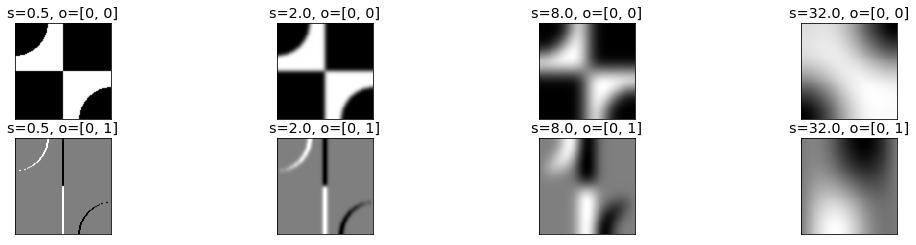

In [40]:
show_gaussian_scale_orders(psychedelic=False)

### Back to lower dimensions

We can do the same with 1D signals

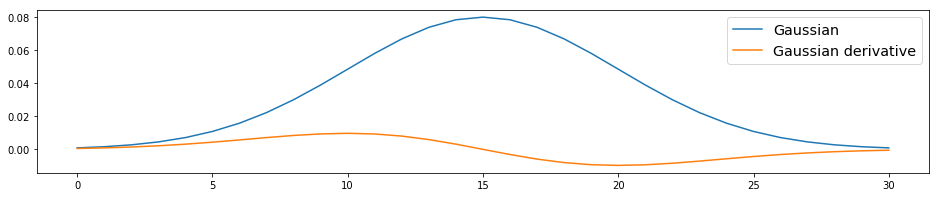

In [41]:
# finally, some custom code for a gaussian function
def g(s=1, o=0, n=9):
    x = arange(n)-int(n/2)
    e = exp( - pow(x, 2) / (2*pow(s,2)) )
    p = sqrt(2 * pi)
    def g_0():
        return e / (s * p)
    def g_1():
        return -(e*x) / ( pow(s, 3) * p )
    return {0: g_0, 1: g_1}[o]()
g0 = g(s=5,o=0,n=31); g1 = g(s=5,o=1,n=31);
plot(g0); plot(g1);
util.legend(['Gaussian', 'Gaussian derivative'])

Convolving the Gaussian filter with a Sobel operator also yields a Gaussian derivative

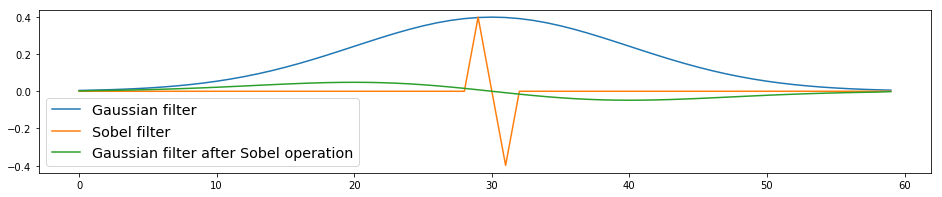

In [42]:
# sub_g holds values of a rather densely sampled Gaussian
sub_g = stats.norm.pdf(arange(-3, 3, .1), 0, 1)
step = zeros(len(sub_g)); step[len(sub_g)/2] = max(sub_g)
plot(sub_g);
plot(ndimage.filters.sobel(step));
plot(ndimage.filters.sobel(sub_g));
util.legend(['Gaussian filter', 'Sobel filter', 'Gaussian filter after Sobel operation'])

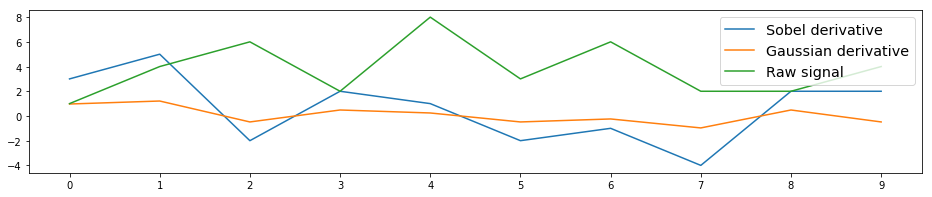

In [43]:
# Raw Sobel filtering
plot(ndimage.filters.sobel(v))
# Gaussian derivative
plot(convolve(g(s=1,o=1,n=3), v, 'same'))
plot(v)
util.legend(['Sobel derivative', 'Gaussian derivative', 'Raw signal'])
xticks(range(len(v))); # so that we can see clearly...
util.figsize()

**Assignment**: can you understand the derivatives? What are the differences between the Sobel derivative and the Gaussian derivative? How come?

And: why is this useful?